In [1]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

# Define folder path
base_folder = "./IDP Group A"

# Define wavelength list (450 nm to 950 nm in 20 nm steps)
wavelengths = list(range(450, 951, 20))

# Define subfolders
sample_folders = [f"d{i}" for i in range(1, 15)]  # d1 to d14
dark_folder = "dark"
white_folder = "white"
reference_folder = "reference image"


# Load white and dark images
def load_cube(folder_path):
    tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".tif")]
    tif_files.sort()

    cube = []
    for tif_file in tif_files:
        tif_path = os.path.join(folder_path, tif_file)
        tif = tiff.imread(tif_path)
        cube.append(tif)

    cube = np.array(cube)

    return cube


# Load dark and white reference cubes
dark_cube = load_cube(os.path.join(base_folder, dark_folder))
white_cube = load_cube(os.path.join(base_folder, white_folder))
reference_cube = load_cube(os.path.join(base_folder, reference_folder))


# Avoid division by zero
denominator = white_cube - dark_cube
denominator[denominator == 0] = 1e-6

# Load and compute reflectance for each sample
reflectance_cubes = {}

for folder in sample_folders:
    sample_cube = load_cube(os.path.join(base_folder, folder))
    R = (sample_cube - dark_cube) / denominator
    reflectance_cubes[folder] = R  # Shape: (bands, height, width)

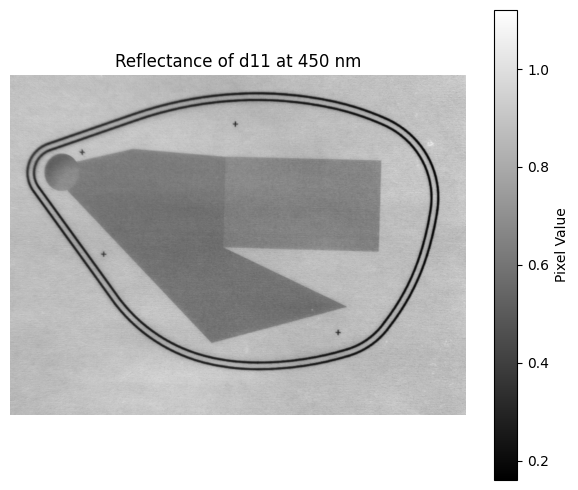

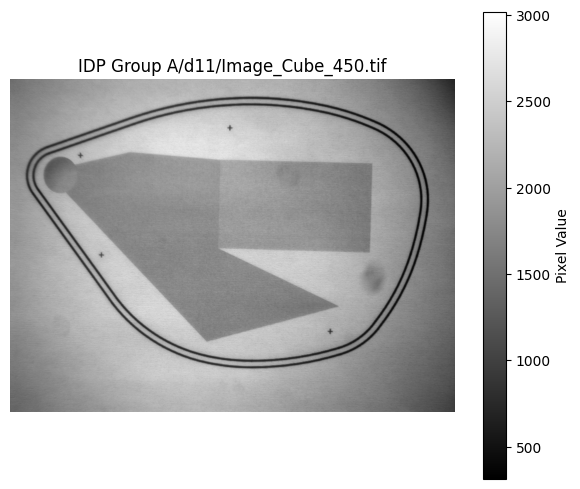

In [2]:
# R_d1 = reflectance_cubes["d1"] # Example: Access reflectance cube for d1


def plot_image(image, title=""):
    # Plot the image
    plt.figure(figsize=(6, 5))
    plt.imshow(image, cmap="gray")
    plt.colorbar(label="Pixel Value")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def plot_example_reflectance(reflectance_cubes, sample_name, wavelength):
    # Get reflectance cube
    R = reflectance_cubes[sample_name]

    # Extract 2D image at selected wavelength
    reflectance_image = R[wavelengths.index(wavelength), :, :]
    title = f"Reflectance of {sample_name} at {wavelength} nm"

    plot_image(reflectance_image, title)


def plot_original_tif(tif_path):
    image = tiff.imread(tif_path)

    plot_image(image, tif_path)


plot_example_reflectance(reflectance_cubes, "d11", 450)
plot_original_tif("IDP Group A/d11/Image_Cube_450.tif")

In [ ]:
reflectance_cubes["d1"][
    [wavelengths.index(470), wavelengths.index(550), wavelengths.index(650)], :, :
]

array([[[0.91073583, 0.87589928, 0.90175864, ..., 1.02456647,
         1.09351433, 1.04776119],
        [0.89922481, 0.87013764, 0.882283  , ..., 0.98550725,
         0.9601707 , 0.97364568],
        [0.90145103, 0.8828125 , 0.91281139, ..., 0.95804196,
         0.98405797, 1.02384501],
        ...,
        [0.84224082, 0.83524904, 0.84294872, ..., 0.96098563,
         0.91929134, 0.96659919],
        [0.85723861, 0.83128636, 0.87073491, ..., 0.93313953,
         0.92611336, 0.99585921],
        [0.84193548, 0.86671001, 0.87044271, ..., 0.9352657 ,
         0.9813278 , 0.89134809]],

       [[0.81795666, 0.78789694, 0.83522013, ..., 0.84718101,
         0.85907046, 0.84660767],
        [0.80168776, 0.77649208, 0.80024969, ..., 0.87407407,
         0.86115214, 0.86094675],
        [0.80317848, 0.81812615, 0.79866586, ..., 0.89055472,
         0.84670487, 0.85778443],
        ...,
        [0.74371859, 0.7748831 , 0.76571429, ..., 0.82948847,
         0.85906736, 0.8468849 ],
        [0.7

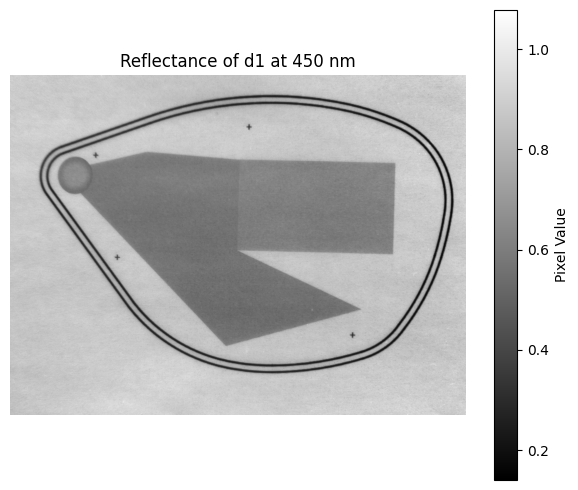

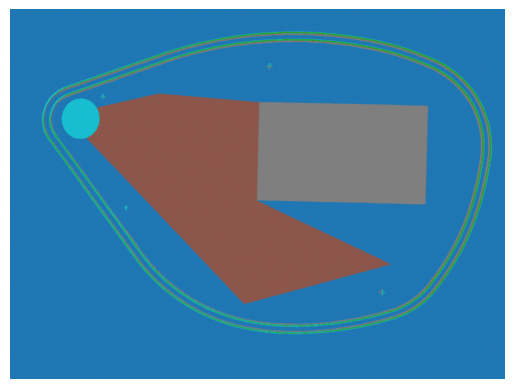

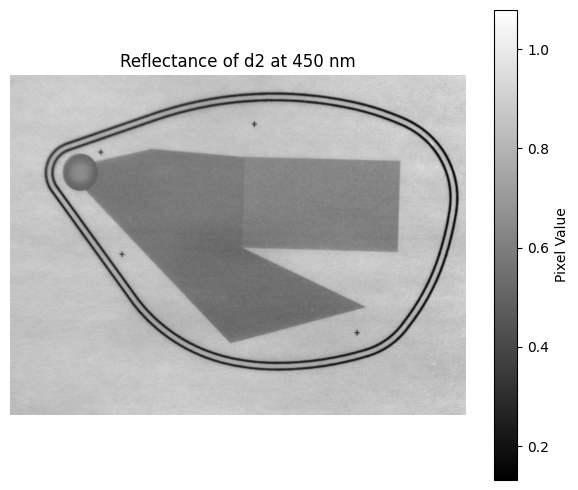

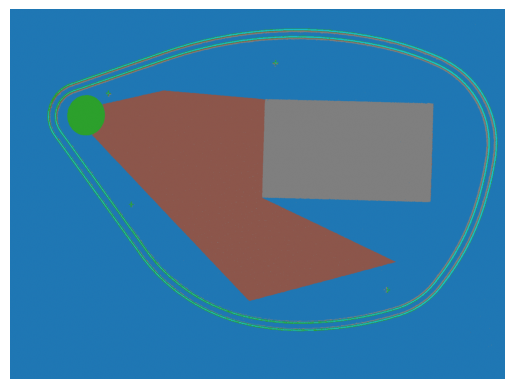

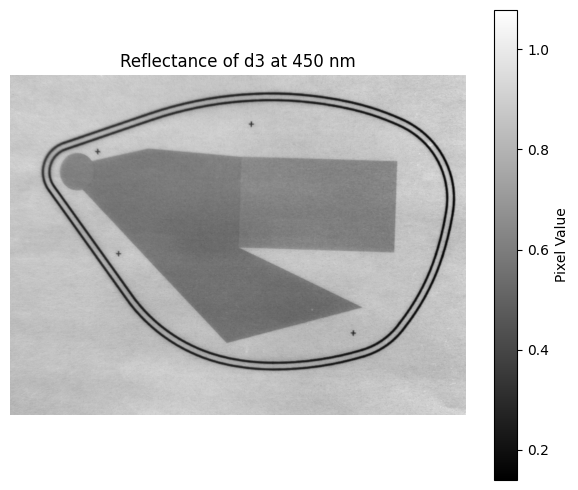

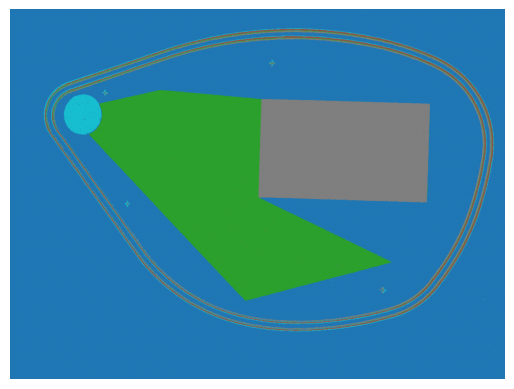

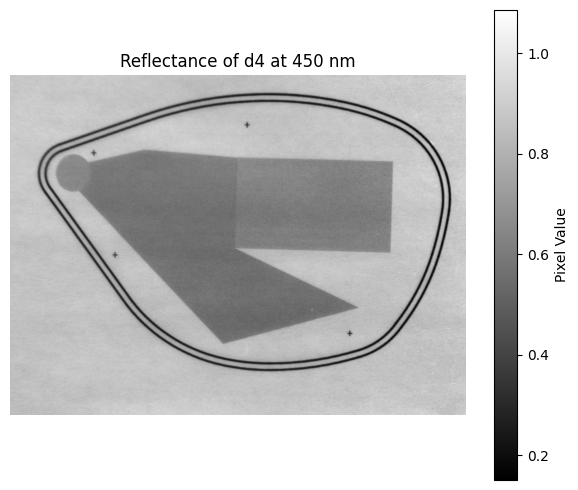

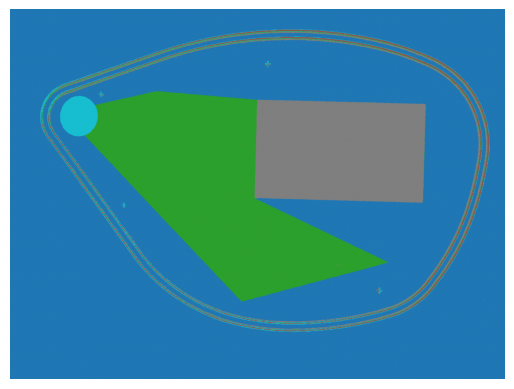

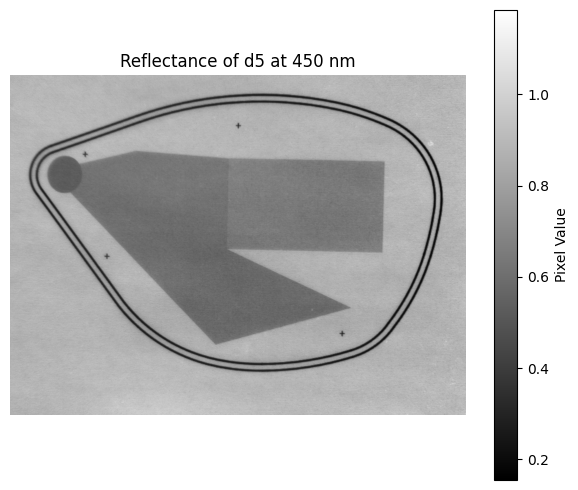

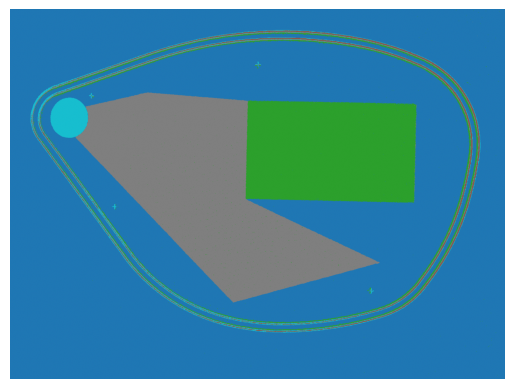

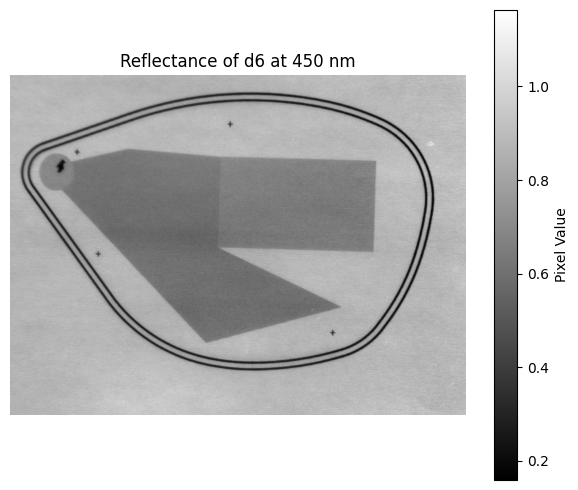

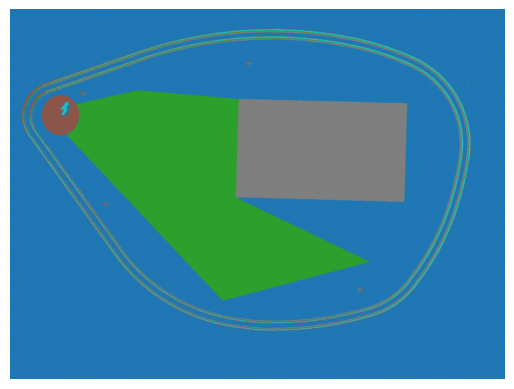

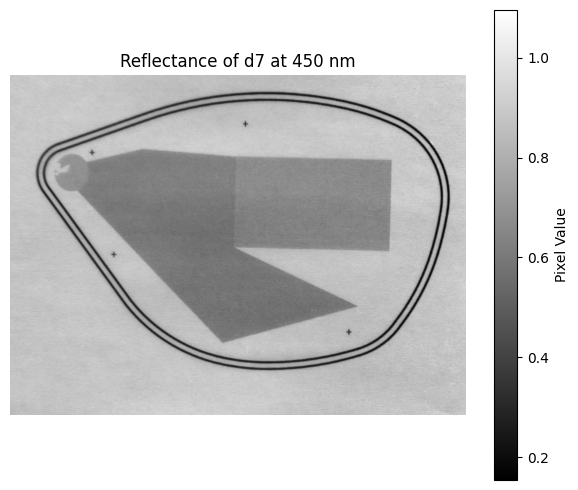

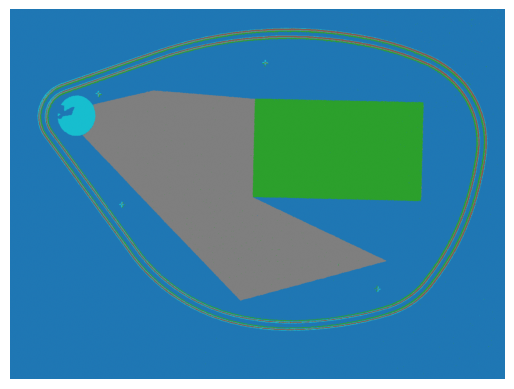

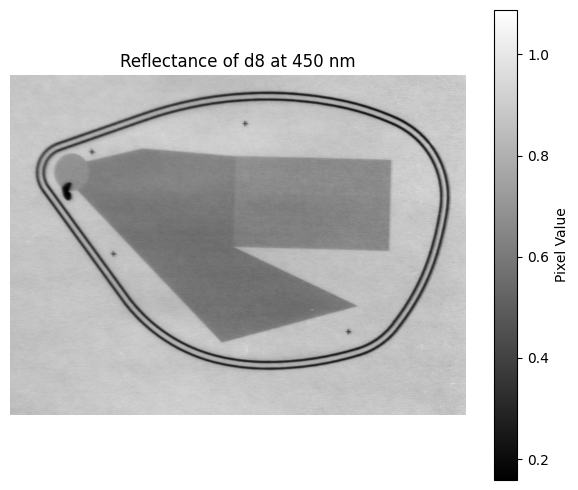

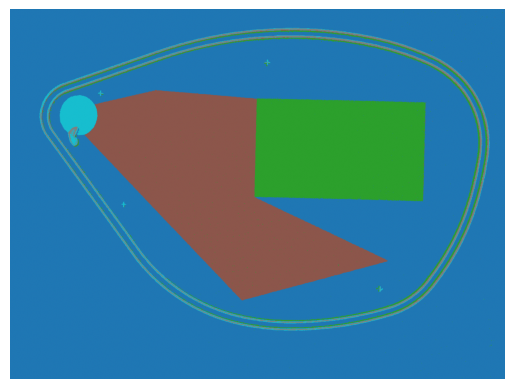

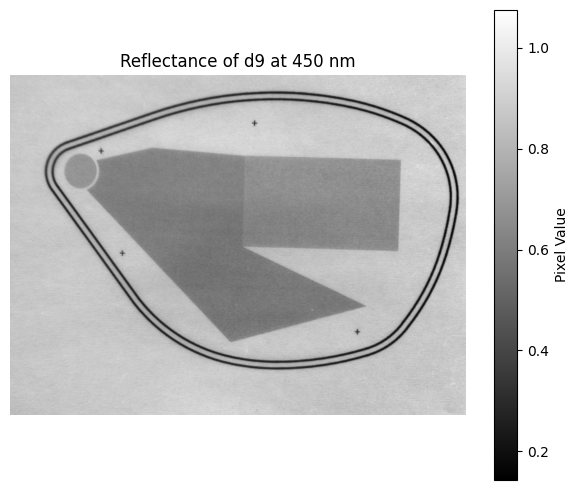

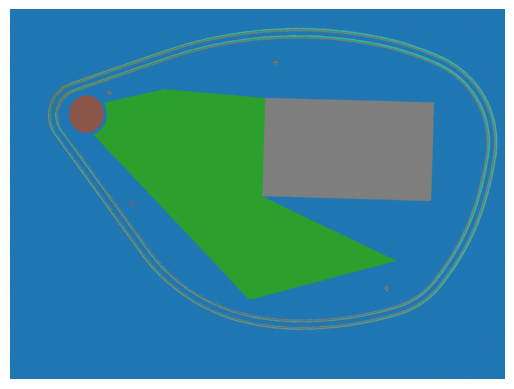

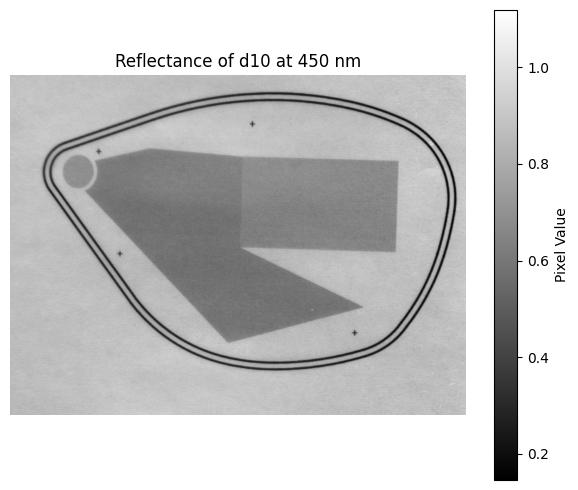

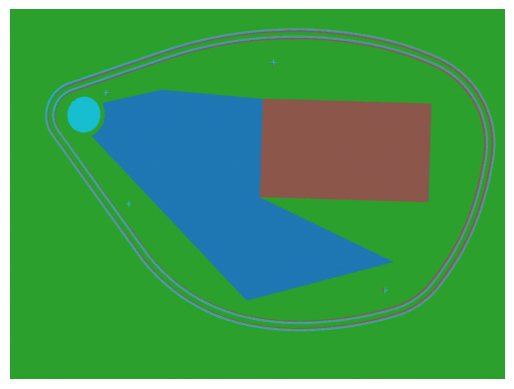

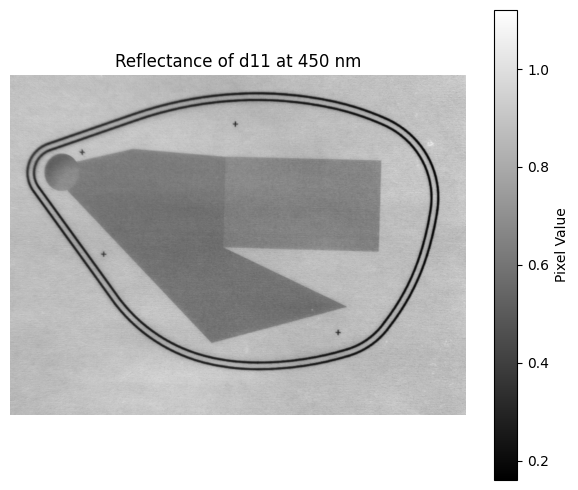

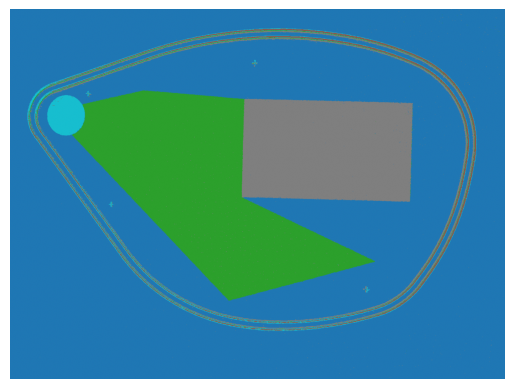

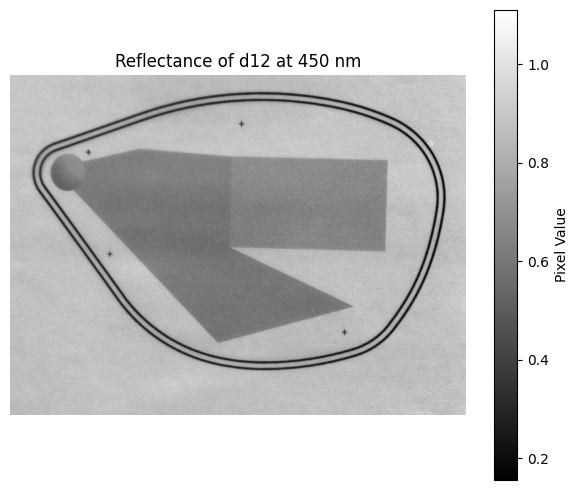

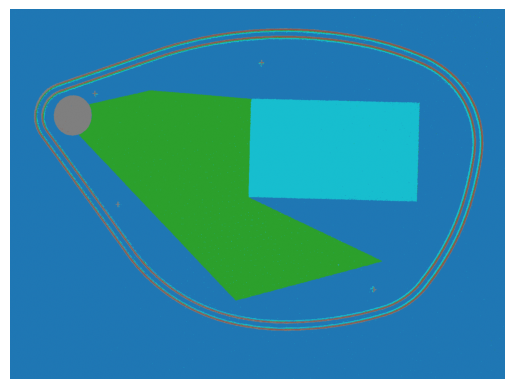

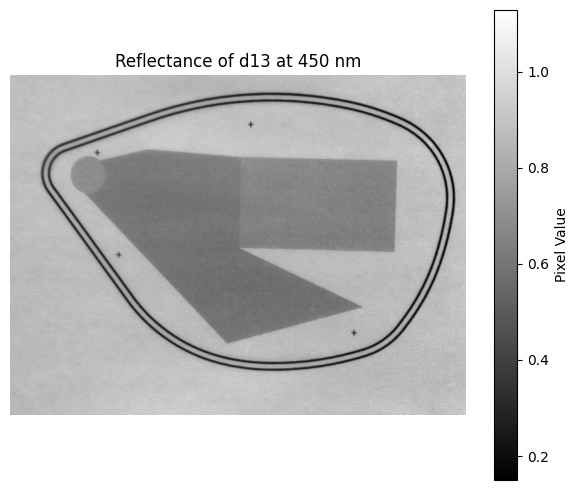

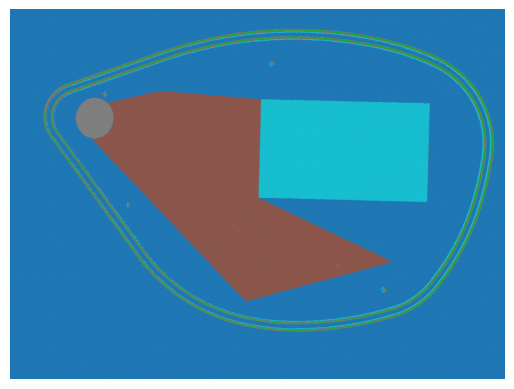

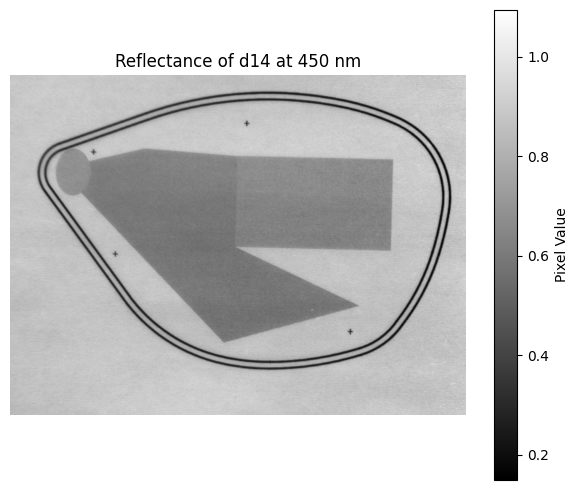

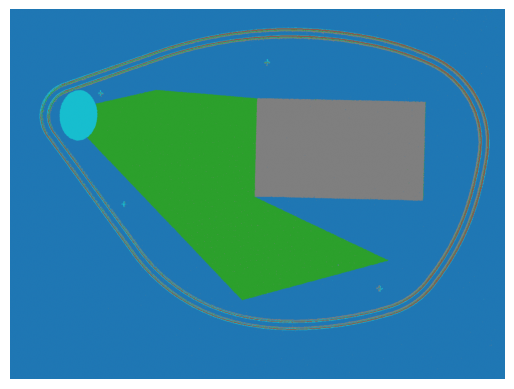

In [ ]:
from sklearn.cluster import KMeans


def segment_image(R):
    bands, height, width = R.shape
    pixels = R.reshape(bands, -1).T
    pixels /= np.linalg.norm(pixels, axis=1, keepdims=True) + 1e-6

    k_means = KMeans(n_clusters=5, random_state=0, n_init=10)
    labels = k_means.fit_predict(pixels)

    segmented_image = labels.reshape(height, width)

    return segmented_image


for d in sample_folders:
    defect = reflectance_cubes[d]
    segmented_image = segment_image(
        defect[
            [wavelengths.index(470), wavelengths.index(550), wavelengths.index(650)],
            :,
            :,
        ]
    )

    plot_example_reflectance(reflectance_cubes, d, 450)

    plt.imshow(segmented_image, cmap="tab10")
    plt.axis("off")
    plt.show()

segmented_image.shape: (1040, 1392)


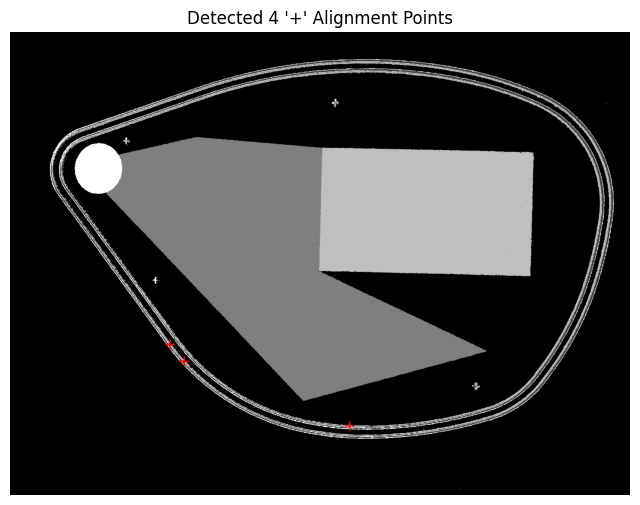

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def segment_image(R):
    bands, height, width = R.shape
    pixels = R.reshape(bands, -1).T
    pixels /= np.linalg.norm(pixels, axis=1, keepdims=True) + 1e-6

    k_means = KMeans(n_clusters=5, random_state=0, n_init=10)
    labels = k_means.fit_predict(pixels)
    return labels.reshape(height, width).astype(np.uint8)


segmented_image = segment_image(
    reflectance_cubes["d1"][
        [wavelengths.index(470), wavelengths.index(550), wavelengths.index(650)], :, :
    ]
)
print(f"segmented_image.shape: {segmented_image.shape}")

img = segmented_image.copy()
if img.max() <= 5:
    img = (img * (255 / img.max())).astype(np.uint8)


_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


# binary = cv2.bitwise_not(binary)

binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))


contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
centres = []

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 50 or area > 2000:
        continue

    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h

    if 0.6 < aspect_ratio < 1.4:
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centres.append((cx, cy))
            cv2.drawMarker(img_color, (cx, cy), (0, 0, 255), cv2.MARKER_CROSS, 20, 2)

if len(centres) > 4:
    Z = np.float32(centres)
    kmeans = KMeans(n_clusters=4, n_init=10, random_state=0).fit(Z)
    centres = np.int32(kmeans.cluster_centers_)

    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for x, y in centres:
        cv2.drawMarker(img_color, (x, y), (0, 255, 0), cv2.MARKER_CROSS, 25, 3)

img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.title("Detected 4 '+' Alignment Points")
plt.axis("off")
plt.show()